In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : [],
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_e_e_1_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(466039, 919)
(466039, 1)
validation
(80707, 919)
(80707, 1)
test
(46831, 919)
(46831, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 919)]             0         


 dense (Dense)               (None, 1024)              942080    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1631233 (6.22 MB)


Trainable params: 1631233 (6.22 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/47 [..............................] - ETA: 58s - loss: 0.0382 - STD: 1.5637e-04 - MAE: 0.1488

 4/47 [=>............................] - ETA: 0s - loss: 0.0280 - STD: 4.0982e-04 - MAE: 0.1336 

 7/47 [===>..........................] - ETA: 0s - loss: 0.0243 - STD: 5.8413e-04 - MAE: 0.1119

10/47 [=====>........................] - ETA: 0s - loss: 0.0232 - STD: 8.2081e-04 - MAE: 0.1029

13/47 [=======>......................] - ETA: 0s - loss: 0.0219 - STD: 0.0011 - MAE: 0.1016    

16/47 [=========>....................] - ETA: 0s - loss: 0.0212 - STD: 0.0014 - MAE: 0.1033

19/47 [===========>..................] - ETA: 0s - loss: 0.0205 - STD: 0.0017 - MAE: 0.0999

21/47 [============>.................] - ETA: 1s - loss: 0.0203 - STD: 0.0019 - MAE: 0.0974

24/47 [==============>...............] - ETA: 1s - loss: 0.0199 - STD: 0.0022 - MAE: 0.0950

26/47 [===============>..............] - ETA: 0s - loss: 0.0196 - STD: 0.0025 - MAE: 0.0946

29/47 [=================>............] - ETA: 0s - loss: 0.0193 - STD: 0.0030 - MAE: 0.0949

32/47 [===================>..........] - ETA: 0s - loss: 0.0189 - STD: 0.0036 - MAE: 0.0937

35/47 [=====================>........] - ETA: 0s - loss: 0.0187 - STD: 0.0043 - MAE: 0.0922

38/47 [=======================>......] - ETA: 0s - loss: 0.0183 - STD: 0.0054 - MAE: 0.0910

40/47 [========================>.....] - ETA: 0s - loss: 0.0181 - STD: 0.0064 - MAE: 0.0906

43/47 [==========================>...] - ETA: 0s - loss: 0.0177 - STD: 0.0083 - MAE: 0.0894

46/47 [============================>.] - ETA: 0s - loss: 0.0172 - STD: 0.0108 - MAE: 0.0878

47/47 [==============================] - 3s 47ms/step - loss: 0.0171 - STD: 0.0118 - MAE: 0.0873 - val_loss: 0.0085 - val_STD: 0.0568 - val_MAE: 0.0589


Epoch 2/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0093 - STD: 0.0673 - MAE: 0.0639

 4/47 [=>............................] - ETA: 0s - loss: 0.0086 - STD: 0.0772 - MAE: 0.0620

 7/47 [===>..........................] - ETA: 0s - loss: 0.0081 - STD: 0.0837 - MAE: 0.0607

10/47 [=====>........................] - ETA: 0s - loss: 0.0077 - STD: 0.0887 - MAE: 0.0591

13/47 [=======>......................] - ETA: 0s - loss: 0.0073 - STD: 0.0898 - MAE: 0.0572

16/47 [=========>....................] - ETA: 0s - loss: 0.0070 - STD: 0.0914 - MAE: 0.0559

19/47 [===========>..................] - ETA: 0s - loss: 0.0067 - STD: 0.0933 - MAE: 0.0547

22/47 [=============>................] - ETA: 0s - loss: 0.0065 - STD: 0.0960 - MAE: 0.0537

24/47 [==============>...............] - ETA: 0s - loss: 0.0064 - STD: 0.0967 - MAE: 0.0531

27/47 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0979 - MAE: 0.0523

30/47 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0987 - MAE: 0.0516

33/47 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.1000 - MAE: 0.0510

36/47 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.1010 - MAE: 0.0505

38/47 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.1015 - MAE: 0.0501

41/47 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.1023 - MAE: 0.0497

44/47 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.1031 - MAE: 0.0492

47/47 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.1036 - MAE: 0.0488

47/47 [==============================] - 1s 25ms/step - loss: 0.0054 - STD: 0.1036 - MAE: 0.0488 - val_loss: 0.0043 - val_STD: 0.0878 - val_MAE: 0.0432


Epoch 3/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0040 - STD: 0.1090 - MAE: 0.0428

 4/47 [=>............................] - ETA: 0s - loss: 0.0039 - STD: 0.1119 - MAE: 0.0424

 7/47 [===>..........................] - ETA: 0s - loss: 0.0039 - STD: 0.1131 - MAE: 0.0424

10/47 [=====>........................] - ETA: 0s - loss: 0.0039 - STD: 0.1134 - MAE: 0.0422

13/47 [=======>......................] - ETA: 0s - loss: 0.0039 - STD: 0.1137 - MAE: 0.0420

16/47 [=========>....................] - ETA: 0s - loss: 0.0038 - STD: 0.1136 - MAE: 0.0419

19/47 [===========>..................] - ETA: 0s - loss: 0.0038 - STD: 0.1136 - MAE: 0.0417

22/47 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.1138 - MAE: 0.0417

25/47 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.1142 - MAE: 0.0415

28/47 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.1144 - MAE: 0.0413

31/47 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.1144 - MAE: 0.0412

34/47 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.1145 - MAE: 0.0411

37/47 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.1145 - MAE: 0.0410

40/47 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.1147 - MAE: 0.0409

43/47 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.1149 - MAE: 0.0408

46/47 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.1150 - MAE: 0.0406

47/47 [==============================] - 1s 24ms/step - loss: 0.0035 - STD: 0.1150 - MAE: 0.0406 - val_loss: 0.0039 - val_STD: 0.0983 - val_MAE: 0.0414


Epoch 4/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.1168 - MAE: 0.0382

 4/47 [=>............................] - ETA: 0s - loss: 0.0031 - STD: 0.1175 - MAE: 0.0384

 7/47 [===>..........................] - ETA: 0s - loss: 0.0031 - STD: 0.1169 - MAE: 0.0384

10/47 [=====>........................] - ETA: 0s - loss: 0.0031 - STD: 0.1173 - MAE: 0.0383

13/47 [=======>......................] - ETA: 0s - loss: 0.0031 - STD: 0.1177 - MAE: 0.0382

15/47 [========>.....................] - ETA: 0s - loss: 0.0031 - STD: 0.1178 - MAE: 0.0380

18/47 [==========>...................] - ETA: 0s - loss: 0.0031 - STD: 0.1178 - MAE: 0.0380

21/47 [============>.................] - ETA: 0s - loss: 0.0030 - STD: 0.1178 - MAE: 0.0379

24/47 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.1177 - MAE: 0.0379

27/47 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.1177 - MAE: 0.0378

30/47 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.1177 - MAE: 0.0378

33/47 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.1179 - MAE: 0.0377

36/47 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1179 - MAE: 0.0377

39/47 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.1182 - MAE: 0.0376

42/47 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1182 - MAE: 0.0376

45/47 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1182 - MAE: 0.0375

47/47 [==============================] - 1s 24ms/step - loss: 0.0030 - STD: 0.1182 - MAE: 0.0374 - val_loss: 0.0038 - val_STD: 0.1028 - val_MAE: 0.0386


Epoch 5/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.1240 - MAE: 0.0360

 4/47 [=>............................] - ETA: 0s - loss: 0.0028 - STD: 0.1203 - MAE: 0.0364

 7/47 [===>..........................] - ETA: 0s - loss: 0.0028 - STD: 0.1191 - MAE: 0.0364

10/47 [=====>........................] - ETA: 0s - loss: 0.0028 - STD: 0.1193 - MAE: 0.0364

12/47 [======>.......................] - ETA: 0s - loss: 0.0028 - STD: 0.1191 - MAE: 0.0362

15/47 [========>.....................] - ETA: 0s - loss: 0.0028 - STD: 0.1192 - MAE: 0.0361

18/47 [==========>...................] - ETA: 0s - loss: 0.0028 - STD: 0.1193 - MAE: 0.0360

21/47 [============>.................] - ETA: 0s - loss: 0.0028 - STD: 0.1195 - MAE: 0.0360

23/47 [=============>................] - ETA: 0s - loss: 0.0027 - STD: 0.1192 - MAE: 0.0359

26/47 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.1193 - MAE: 0.0359

29/47 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.1195 - MAE: 0.0359

32/47 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.1194 - MAE: 0.0359

35/47 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1193 - MAE: 0.0358

38/47 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1195 - MAE: 0.0358

41/47 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1195 - MAE: 0.0358

44/47 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1195 - MAE: 0.0357

47/47 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1195 - MAE: 0.0356

47/47 [==============================] - 1s 24ms/step - loss: 0.0027 - STD: 0.1195 - MAE: 0.0356 - val_loss: 0.0038 - val_STD: 0.1029 - val_MAE: 0.0381


Epoch 6/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0027 - STD: 0.1205 - MAE: 0.0352

 4/47 [=>............................] - ETA: 0s - loss: 0.0027 - STD: 0.1193 - MAE: 0.0353

 7/47 [===>..........................] - ETA: 0s - loss: 0.0027 - STD: 0.1194 - MAE: 0.0354

10/47 [=====>........................] - ETA: 0s - loss: 0.0027 - STD: 0.1198 - MAE: 0.0353

13/47 [=======>......................] - ETA: 0s - loss: 0.0027 - STD: 0.1201 - MAE: 0.0356

16/47 [=========>....................] - ETA: 0s - loss: 0.0027 - STD: 0.1198 - MAE: 0.0355

19/47 [===========>..................] - ETA: 0s - loss: 0.0027 - STD: 0.1200 - MAE: 0.0355

22/47 [=============>................] - ETA: 0s - loss: 0.0027 - STD: 0.1201 - MAE: 0.0355

24/47 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1199 - MAE: 0.0355

27/47 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.1198 - MAE: 0.0356

30/47 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.1199 - MAE: 0.0355

33/47 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1199 - MAE: 0.0356

36/47 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1197 - MAE: 0.0357

39/47 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1195 - MAE: 0.0358

42/47 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1196 - MAE: 0.0359

45/47 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1197 - MAE: 0.0358

47/47 [==============================] - 1s 25ms/step - loss: 0.0027 - STD: 0.1197 - MAE: 0.0358 - val_loss: 0.0035 - val_STD: 0.0994 - val_MAE: 0.0374


Epoch 7/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0026 - STD: 0.1203 - MAE: 0.0346

 4/47 [=>............................] - ETA: 0s - loss: 0.0026 - STD: 0.1201 - MAE: 0.0347

 6/47 [==>...........................] - ETA: 0s - loss: 0.0026 - STD: 0.1190 - MAE: 0.0346

 9/47 [====>.........................] - ETA: 0s - loss: 0.0026 - STD: 0.1196 - MAE: 0.0346

12/47 [======>.......................] - ETA: 0s - loss: 0.0025 - STD: 0.1197 - MAE: 0.0344

15/47 [========>.....................] - ETA: 0s - loss: 0.0025 - STD: 0.1197 - MAE: 0.0343

18/47 [==========>...................] - ETA: 0s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0342

21/47 [============>.................] - ETA: 0s - loss: 0.0025 - STD: 0.1202 - MAE: 0.0341

24/47 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0340

27/47 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0340

30/47 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0340

33/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0340

36/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0340

39/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0340

42/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0341

45/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0341

47/47 [==============================] - 1s 24ms/step - loss: 0.0025 - STD: 0.1204 - MAE: 0.0341 - val_loss: 0.0037 - val_STD: 0.1019 - val_MAE: 0.0386


Epoch 8/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.1217 - MAE: 0.0344

 3/47 [>.............................] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0343

 6/47 [==>...........................] - ETA: 0s - loss: 0.0024 - STD: 0.1201 - MAE: 0.0338

 9/47 [====>.........................] - ETA: 0s - loss: 0.0024 - STD: 0.1200 - MAE: 0.0337

12/47 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.1194 - MAE: 0.0338

15/47 [========>.....................] - ETA: 0s - loss: 0.0024 - STD: 0.1197 - MAE: 0.0337

18/47 [==========>...................] - ETA: 0s - loss: 0.0024 - STD: 0.1202 - MAE: 0.0336

21/47 [============>.................] - ETA: 0s - loss: 0.0024 - STD: 0.1200 - MAE: 0.0335

24/47 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.1200 - MAE: 0.0335

27/47 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.1204 - MAE: 0.0335

30/47 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1204 - MAE: 0.0335

33/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0334

36/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0334

39/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0334

43/47 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0334

46/47 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0335

47/47 [==============================] - 1s 25ms/step - loss: 0.0024 - STD: 0.1209 - MAE: 0.0335 - val_loss: 0.0038 - val_STD: 0.1014 - val_MAE: 0.0394


Epoch 9/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0333

 4/47 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0332

 7/47 [===>..........................] - ETA: 0s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0331

10/47 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.1210 - MAE: 0.0330

13/47 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.1208 - MAE: 0.0329

16/47 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1210 - MAE: 0.0331

19/47 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0332

22/47 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0332

25/47 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0332

28/47 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0332

32/47 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0337

35/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0339

38/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0340

41/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0340

44/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0339

47/47 [==============================] - 1s 23ms/step - loss: 0.0024 - STD: 0.1209 - MAE: 0.0339 - val_loss: 0.0035 - val_STD: 0.0964 - val_MAE: 0.0382


Epoch 10/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.1205 - MAE: 0.0335

 5/47 [==>...........................] - ETA: 0s - loss: 0.0023 - STD: 0.1205 - MAE: 0.0332

 8/47 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.1207 - MAE: 0.0334

11/47 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.1207 - MAE: 0.0333

14/47 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.1205 - MAE: 0.0332

17/47 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1206 - MAE: 0.0331

20/47 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.1207 - MAE: 0.0331

23/47 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1208 - MAE: 0.0331

26/47 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.1210 - MAE: 0.0331

29/47 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0331

32/47 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0331

35/47 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0331

38/47 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0330

41/47 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0330

44/47 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0329

47/47 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0329

47/47 [==============================] - 1s 22ms/step - loss: 0.0023 - STD: 0.1212 - MAE: 0.0329 - val_loss: 0.0041 - val_STD: 0.1021 - val_MAE: 0.0426


Epoch 11/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.1254 - MAE: 0.0343

 4/47 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.1208 - MAE: 0.0332

 7/47 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.1214 - MAE: 0.0327

10/47 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0330

13/47 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0331

16/47 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0330

19/47 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.1214 - MAE: 0.0329

22/47 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0331

25/47 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0331

28/47 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0331

31/47 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0332

34/47 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0332

38/47 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0333

41/47 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0333

44/47 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0333

47/47 [==============================] - 1s 22ms/step - loss: 0.0023 - STD: 0.1214 - MAE: 0.0332 - val_loss: 0.0036 - val_STD: 0.0992 - val_MAE: 0.0394


Epoch 12/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.1263 - MAE: 0.0325

 4/47 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.1235 - MAE: 0.0321

 7/47 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.1234 - MAE: 0.0321

10/47 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.1234 - MAE: 0.0328

13/47 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.1229 - MAE: 0.0327

16/47 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.1224 - MAE: 0.0329

19/47 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0327

22/47 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0327

25/47 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1220 - MAE: 0.0326

28/47 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0327

31/47 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0327

34/47 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0328

37/47 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0327

40/47 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0326

43/47 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0326

46/47 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0325

47/47 [==============================] - 1s 21ms/step - loss: 0.0022 - STD: 0.1217 - MAE: 0.0325 - val_loss: 0.0036 - val_STD: 0.0973 - val_MAE: 0.0403


Epoch 13/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0326

 4/47 [=>............................] - ETA: 0s - loss: 0.0024 - STD: 0.1220 - MAE: 0.0345

 7/47 [===>..........................] - ETA: 0s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0352

10/47 [=====>........................] - ETA: 0s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0347

13/47 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0342

16/47 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0338

19/47 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0338

22/47 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0337

25/47 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0335

28/47 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0334

31/47 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0332

34/47 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0331

37/47 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0330

40/47 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0330

43/47 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0329

47/47 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0328

47/47 [==============================] - 1s 21ms/step - loss: 0.0022 - STD: 0.1217 - MAE: 0.0328 - val_loss: 0.0038 - val_STD: 0.0991 - val_MAE: 0.0419


Epoch 14/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0020 - STD: 0.1233 - MAE: 0.0309

 4/47 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.1224 - MAE: 0.0317

 7/47 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0326

10/47 [=====>........................] - ETA: 0s - loss: 0.0021 - STD: 0.1221 - MAE: 0.0324

13/47 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.1220 - MAE: 0.0326

16/47 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.1220 - MAE: 0.0326

19/47 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.1220 - MAE: 0.0328

22/47 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0328

25/47 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0328

29/47 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0328

32/47 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1220 - MAE: 0.0328

35/47 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1220 - MAE: 0.0328

38/47 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1221 - MAE: 0.0328

41/47 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1220 - MAE: 0.0327

44/47 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1220 - MAE: 0.0327

47/47 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1220 - MAE: 0.0326

47/47 [==============================] - 1s 21ms/step - loss: 0.0022 - STD: 0.1220 - MAE: 0.0326 - val_loss: 0.0037 - val_STD: 0.0958 - val_MAE: 0.0413


Epoch 15/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.1220 - MAE: 0.0326

 4/47 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.1218 - MAE: 0.0317

 7/47 [===>..........................] - ETA: 0s - loss: 0.0021 - STD: 0.1221 - MAE: 0.0318

10/47 [=====>........................] - ETA: 0s - loss: 0.0021 - STD: 0.1218 - MAE: 0.0316

13/47 [=======>......................] - ETA: 0s - loss: 0.0020 - STD: 0.1215 - MAE: 0.0316

16/47 [=========>....................] - ETA: 0s - loss: 0.0020 - STD: 0.1222 - MAE: 0.0316

19/47 [===========>..................] - ETA: 0s - loss: 0.0020 - STD: 0.1224 - MAE: 0.0316

22/47 [=============>................] - ETA: 0s - loss: 0.0020 - STD: 0.1224 - MAE: 0.0315

25/47 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.1226 - MAE: 0.0315

28/47 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.1224 - MAE: 0.0318

31/47 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.1224 - MAE: 0.0318

34/47 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1223 - MAE: 0.0317

37/47 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1223 - MAE: 0.0317

40/47 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1224 - MAE: 0.0317

43/47 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1223 - MAE: 0.0317

46/47 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1224 - MAE: 0.0316

47/47 [==============================] - 1s 21ms/step - loss: 0.0020 - STD: 0.1224 - MAE: 0.0316 - val_loss: 0.0039 - val_STD: 0.0969 - val_MAE: 0.0431


Epoch 16/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.1201 - MAE: 0.0326

 4/47 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.1209 - MAE: 0.0319

 7/47 [===>..........................] - ETA: 0s - loss: 0.0021 - STD: 0.1218 - MAE: 0.0316

10/47 [=====>........................] - ETA: 0s - loss: 0.0020 - STD: 0.1222 - MAE: 0.0318

13/47 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.1220 - MAE: 0.0329

16/47 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0341

19/47 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.1219 - MAE: 0.0340

22/47 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0339

25/47 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0337

28/47 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0336

31/47 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0336

35/47 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1220 - MAE: 0.0337

38/47 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1221 - MAE: 0.0339

41/47 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1219 - MAE: 0.0340

44/47 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0342

47/47 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0342

47/47 [==============================] - 1s 21ms/step - loss: 0.0023 - STD: 0.1216 - MAE: 0.0342 - val_loss: 0.0036 - val_STD: 0.0971 - val_MAE: 0.0405


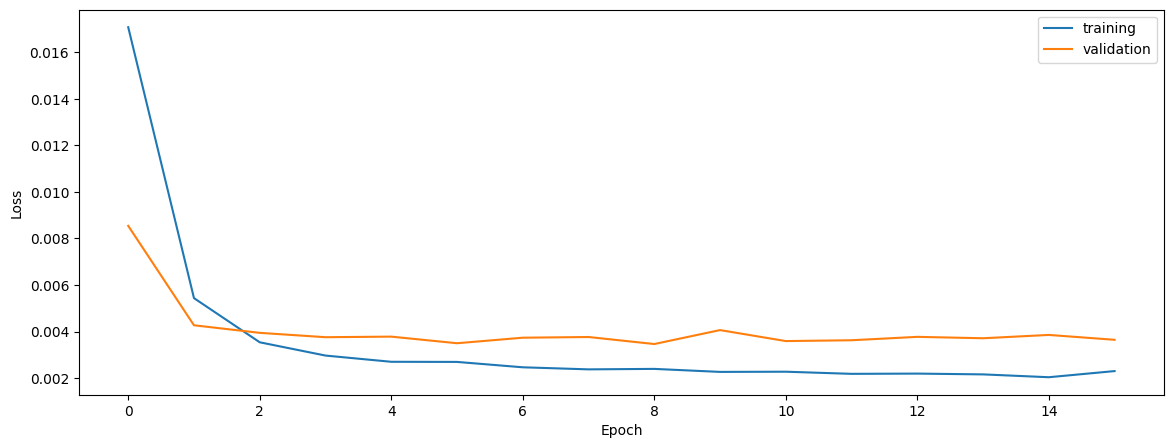

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9315409087187667
0.8862997926586554
0.942591682452312


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9315409087187667
0.8862997926586554
0.942591682452312


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9365549483842543
0.9026102744547597
0.9433213415239664


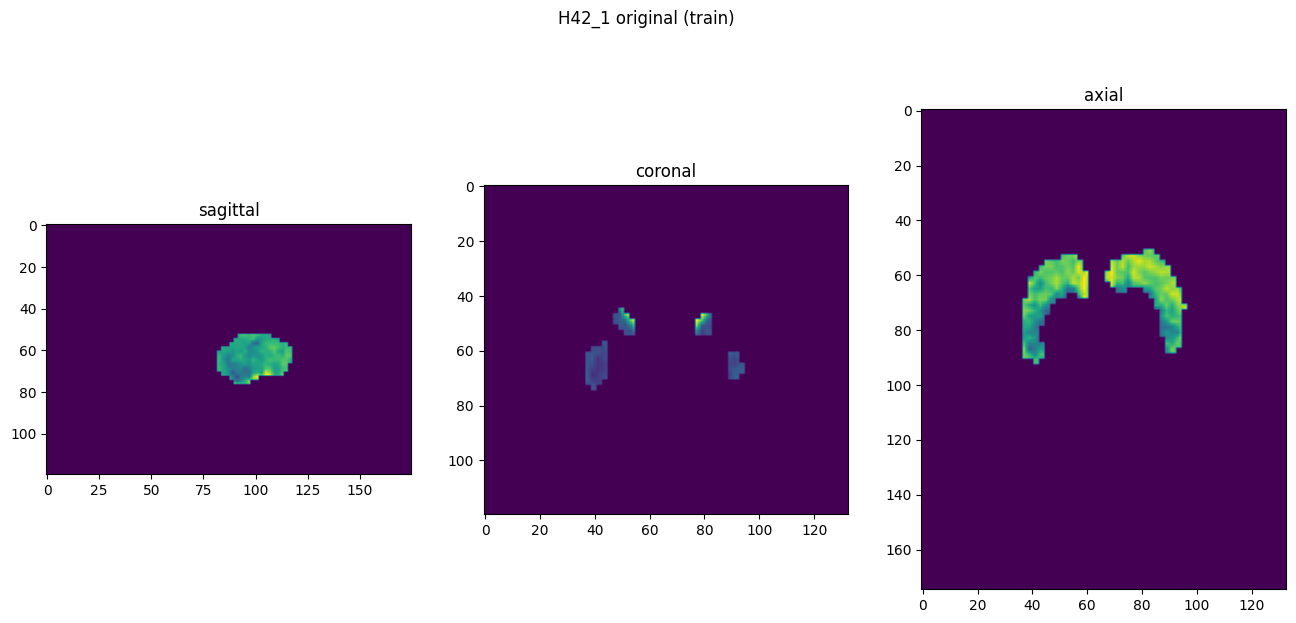

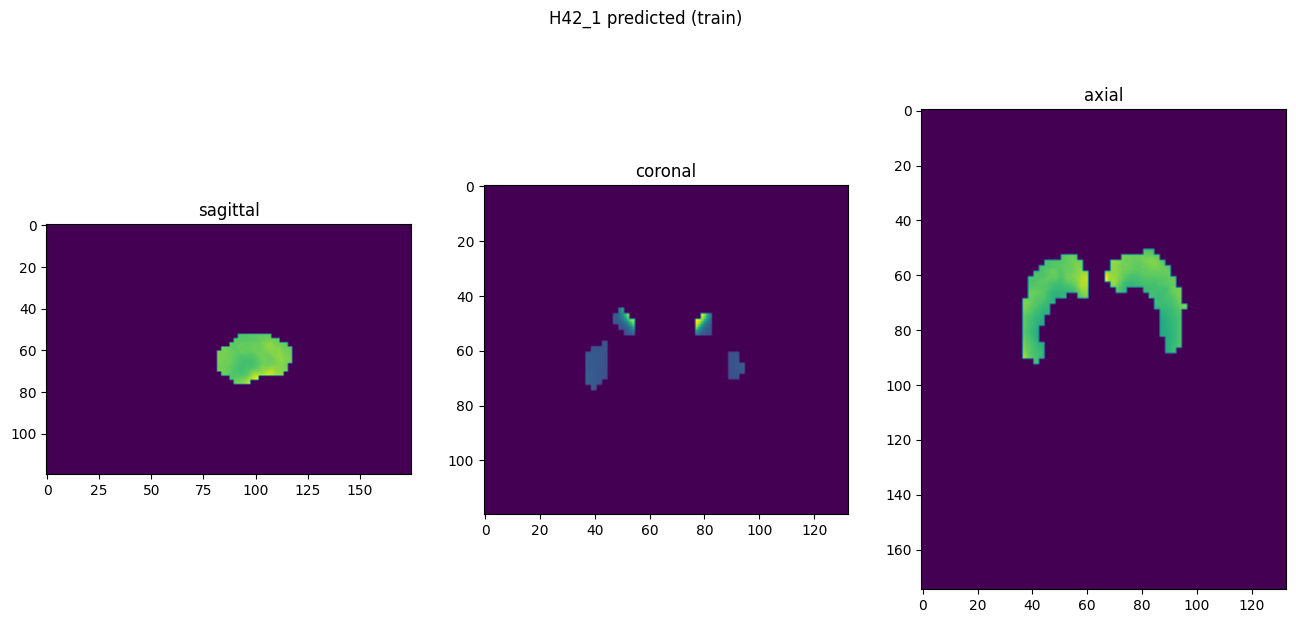

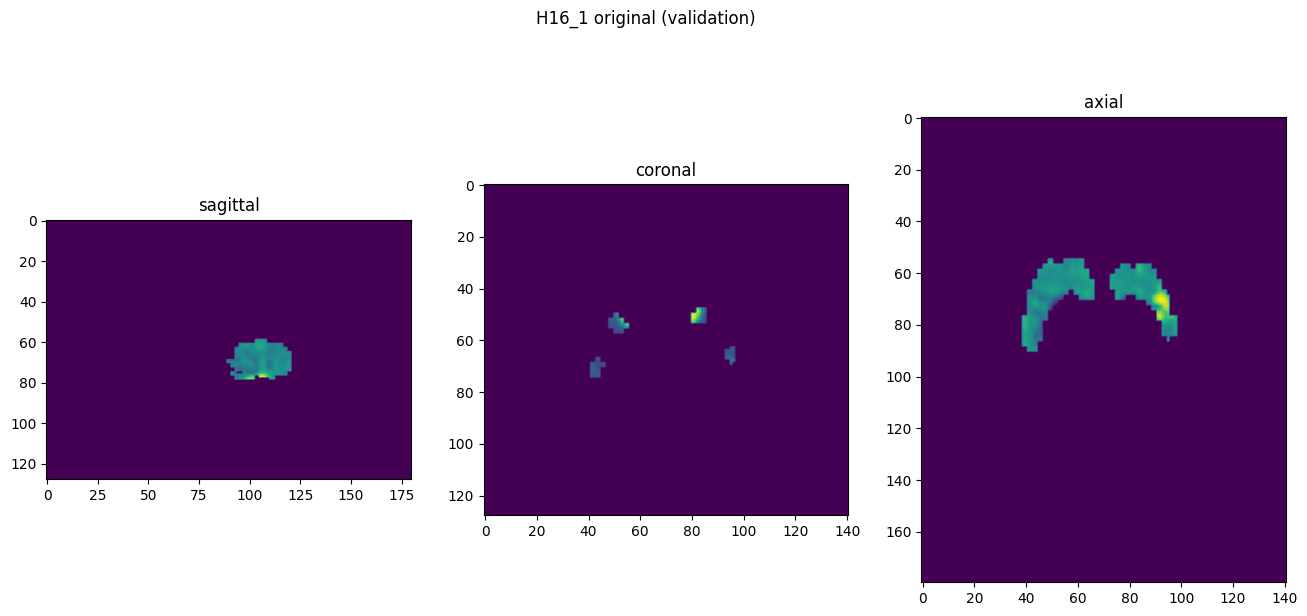

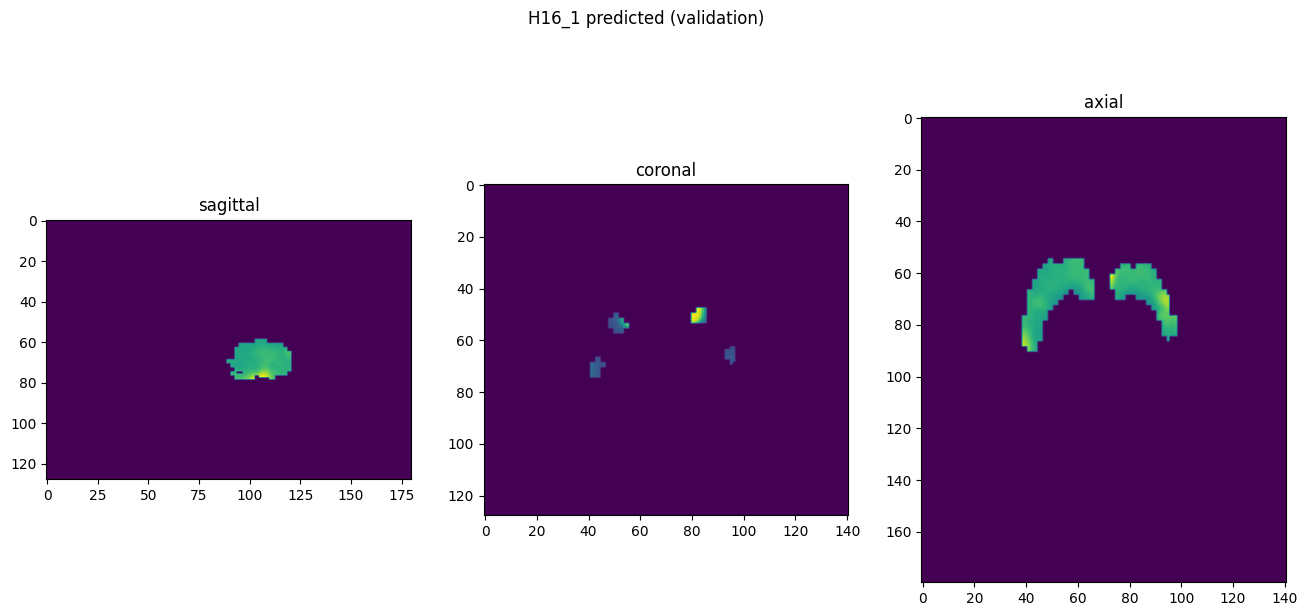

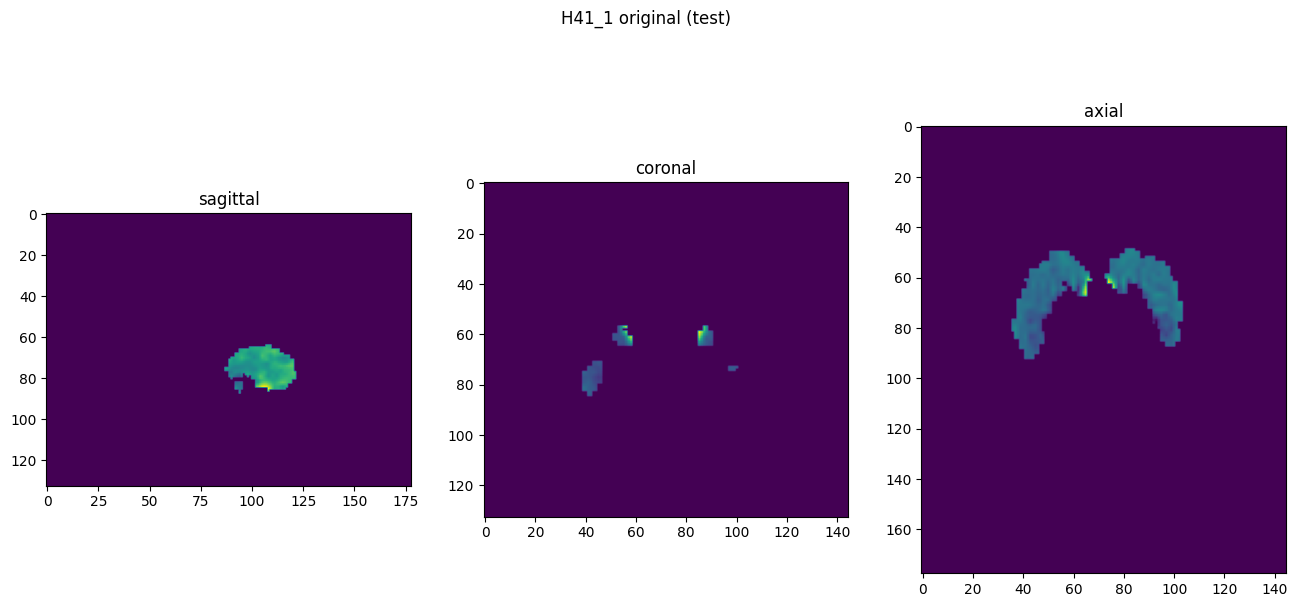

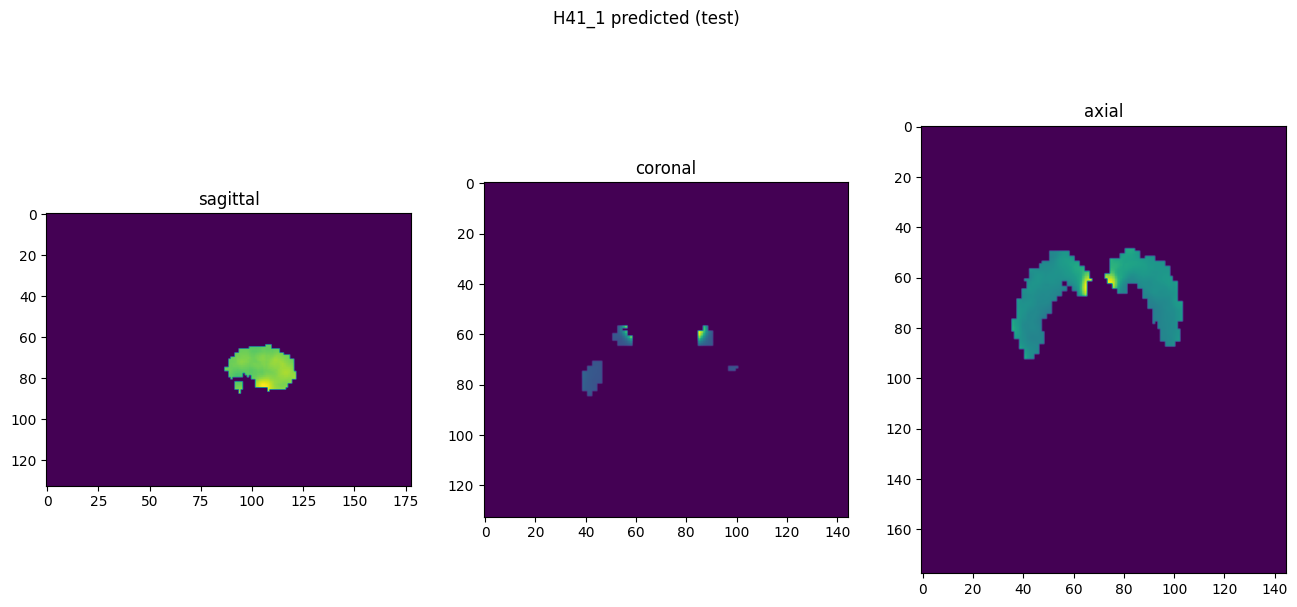

In [10]:
showResults(model, gen, threshold=None, background=False)